<a href="https://colab.research.google.com/github/vir-k01/ML-and-DL/blob/main/Techsoc_CVi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [ ]:
import pandas as pd

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array 

In [ ]:
from keras.applications import VGG16
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -q kaggle

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.12

Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 1.5MB 9.1MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 4.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=c47faab994531b441a475acffcdcb8db88ebc5bcf7f7332f4c09cb352245127b
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle


In [ ]:
#upload kaggle api key
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle competitions download -c dl-hack-track-1-cv

100% 14.5G/14.5G [06:00<00:01, 6.29MB/s]
100% 14.5G/14.5G [06:00<00:00, 43.2MB/s]


In [ ]:
!unzip /content/dl-hack-track-1-cv.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/real/5499.png     
  inflating: train/real/55.png       
  inflating: train/real/550.png      
  inflating: train/real/5500.png     
  inflating: train/real/5501.png     
  inflating: train/real/5502.png     
  inflating: train/real/5503.png     
  inflating: train/real/5504.png     
  inflating: train/real/5505.png     
  inflating: train/real/5506.png     
  inflating: train/real/5507.png     
  inflating: train/real/5508.png     
  inflating: train/real/5509.png     
  inflating: train/real/551.png      
  inflating: train/real/5510.png     
  inflating: train/real/5511.png     
  inflating: train/real/5512.png     
  inflating: train/real/5513.png     
  inflating: train/real/5514.png     
  inflating: train/real/5515.png     
  inflating: train/real/5516.png     
  inflating: train/real/5517.png     
  inflating: train/real/5518.png     
  inflating: train/real/5519.png     
  inflating: train/real/552.png      

In [ ]:
!rm /content/dl-hack-track-1-cv.zip

In [ ]:
batch_size = 32
img_height = 512
img_width = 512

In [ ]:
data_dir = '/content/train'

In [ ]:
def make_submission(model):
  pred = []
  for id in range(5000):
    img = load_img('/content/test/' + str(id)+'.png')
    img = img_to_array(img)
    img = np.expand_dims(img, 0)
    pred.append(model.predict(img))
    prob_real = np.array(pred)
  # clip predicted probabilties to avoid infinite error
  prob_real = np.clip(prob_real, 0.025, 0.975)

  df = pd.DataFrame()
  df["id"] = np.arange(len(pred))
  df["p_real"] = pred
  df['p_real'] = df['p_real'].str.extract("([-+]?\d*\.\d+|[-+]?\d+)").astype(float)
  df.to_csv("submission_" + str(model)+".csv", index=False)
  return prob_real

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 35000 files belonging to 2 classes.
Using 28000 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 35000 files belonging to 2 classes.
Using 7000 files for validation.


In [ ]:
class_names[0]

'fake'

In [ ]:
class_names = train_ds.class_names
print(class_names)

['fake', 'real']


In [ ]:
train_ds

<BatchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>

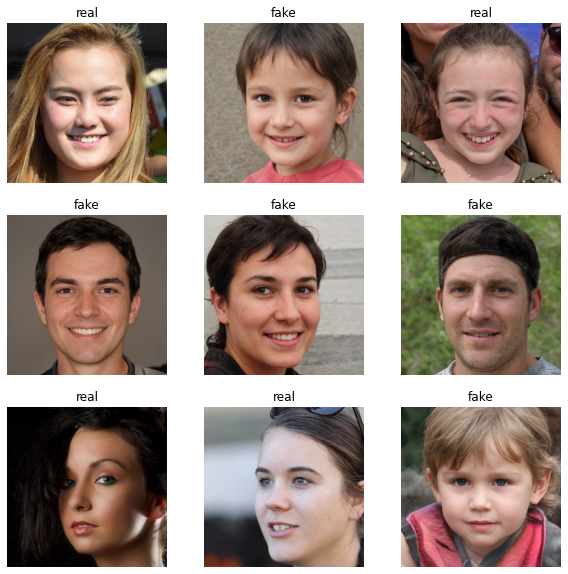

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [ ]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of train batches: 875
Number of validation batches: 176
Number of test batches: 43


In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 1], dtype=int32)>

In [ ]:
#hyperparameters
#pooling = 'avg' or 'max'
dense_nodes = 1024
dense_layers = 1
epochs = 5
#BATCH SIZE = 32
lr = 0.0001

In [ ]:
model = VGG16(include_top= False, input_shape= (512, 512, 3)) #try pool as avg or max
for layer in model.layers:
  layer.trainable = False
flat = keras.layers.Flatten()(model.layers[-1].output)
dense = keras.layers.Dense(dense_nodes)(flat)
for i in range(dense_layers-1):
  dense = keras.layers.Dense(dense_nodes, activation = 'relu')(dense) 
output = keras.layers.Dense(1, activation='sigmoid')(dense)
final_model = Model(inputs = model.inputs, outputs = output)
final_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0   

In [ ]:
final_model.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.BinaryCrossentropy(from_logits = False, label_smoothing=0.2), metrics = ['accuracy'])

In [ ]:
checkpoint_path = '/checkpoints'

In [ ]:
callbacks = [
    #tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=2), #something that can be tried
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'), 
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

]
#%tensorboard --logdir=/logs #run for tensorboard visualizations later

In [ ]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard

In [ ]:
#%tensorboard --logdir=/logs

In [ ]:
hist = final_model.fit(train_ds,validation_data =val_ds, epochs= 3, callbacks= callbacks, verbose = 1)

Epoch 1/3
875/875 [==============================] - 757s 861ms/step - loss: 32.4952 - accuracy: 0.8992 - val_loss: 0.3886 - val_accuracy: 0.9835
Epoch 2/3
875/875 [==============================] - 756s 859ms/step - loss: 0.9628 - accuracy: 0.9391 - val_loss: 0.3789 - val_accuracy: 0.9868


ResourceExhaustedError: ignored

In [ ]:
def plot_losses(history):
  # plot loss during training
	plt.subplot(211)
	plt.title('Loss')
	plt.plot(history.history['loss'], label='train')
	plt.plot(history.history['val_loss'], label='test')
	plt.legend()
	# plot accuracy during training
	plt.subplot(212)
	plt.title('Accuracy')
	plt.plot(history.history['accuracy'], label='train')
	plt.plot(history.history['val_accuracy'], label='test')
	plt.legend()
	plt.show()

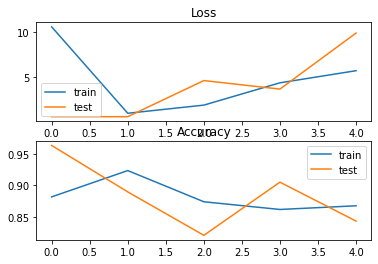

In [ ]:
plot_losses(hist)
#add function for checking log loss

In [ ]:
final_model.save('model.h5')

In [ ]:
trained_model = keras.models.load_model('/content/model.02-0.37.h5')

In [ ]:
trained_model.compile(optimizer='Adam', loss = keras.losses.BinaryCrossentropy(label_smoothing=0.2))

In [ ]:
trained_model.evaluate(val_ds)

176/176 [==============================] - 146s 678ms/step - loss: 0.3686


0.36857181787490845

In [ ]:
final_model.evaluate(val_ds)

176/176 [==============================] - 146s 668ms/step - loss: 0.3786 - accuracy: 0.9868


[0.37858158349990845, 0.9868420958518982]

In [ ]:
trained_model.evaluate(test_ds)

43/43 [==============================] - 33s 700ms/step - loss: 0.3673


0.36734795570373535

In [ ]:
final_model.evaluate(test_ds)

43/43 [==============================] - 32s 665ms/step - loss: 0.4607 - accuracy: 0.9855


[0.4606795608997345, 0.9854651093482971]

In [ ]:
img = tf.keras.preprocessing.image.load_img('/content/train/fake/1.png')
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = final_model.predict(img_array)

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
labels_batch

In [ ]:
pred_1 = trained_model.predict(image_batch)

In [ ]:
pred = final_model.predict(image_batch)

In [ ]:
final_model.predict(image_batch)

In [ ]:
def cross_entropy(predictions, targets):
    N = predictions.shape[0]
    ce = -np.sum(targets * np.log(predictions)) / N
    return ce

In [ ]:
cross_entropy(pred_1, labels_batch)

0.0

In [ ]:
cross_entropy(pred, labels_batch)

0.0

In [ ]:
log_loss(labels_batch, pred_1)

0.6644041268154979

In [ ]:
log_loss(labels_batch, pred)

0.6606592843309045

In [ ]:
predictions

array([[0.03054702]], dtype=float32)

In [ ]:
np.argmax(score)

In [ ]:
score

In [ ]:
score = predictions[0]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predictions)], 100 * np.max(predictions))
)


This image most likely belongs to fake with a 2.03 percent confidence.


In [ ]:
img = np.asarray(img)
img = np.expand_dims(img, axis = 0)
img = np.reshape(img, (512, 512, 3))